# Configuracion

In [1]:
!git clone https://github.com/KristofPusztai/EQL.git
%cd EQL
!pip install tf_keras numpy sympy matplotlib
import os
os.environ["TF_USE_LEGACY_KERAS"] = "True"

Cloning into 'EQL'...
remote: Enumerating objects: 365, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 365 (delta 21), reused 39 (delta 12), pack-reused 304 (from 1)
Receiving objects: 100% (365/365), 786.72 KiB | 3.12 MiB/s, done.
Resolving deltas: 100% (168/168), done.
/content/EQL


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from EQL.model import EQL
from sympy import symbols, lambdify
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os, itertools, random, sympy as sp
import matplotlib.pyplot as plt

# Nguyen

## Funciones Utiles para Nguyen

In [5]:
def generate_nguyen_data(func_id, n_samples=512, extrapolation=False):
    """
    Genera dataset sintético para funciones Nguyen-1 a 5.
    """
    rng = np.random.default_rng()
    # Definiciones del paper Nguyen (Uy et al., 2010)
    x = None
    if func_id == 1:
        f = lambda x: x**3 + x**2 + x
        dim = 1
    elif func_id == 2:
        f = lambda x: x**4 + x**3 + x**2 + x
        dim = 1
    elif func_id == 3:
        f = lambda x: x**5 + x**4 + x**3 + x**2 + x
        dim = 1
    elif func_id == 4:
        f = lambda x: np.sin(x**2)
        dim = 1
    elif func_id == 5:
        f = lambda x: np.sin(x**2)*np.cos(x) - 1
        dim = 1
    elif func_id == 6:
        f = lambda x: np.sin(x) + np.sin(x + x**2)
        dim = 1
    elif func_id == 9:
        f = lambda x1, x2: np.sin(x1) + np.sin(x2**2)
        dim = 2
    elif func_id == 10:
        f = lambda x1, x2: 2*np.sin(x1)*np.cos(x2)
        dim = 2
    else:
        raise ValueError("func_id debe ser 1–6, 9 o 10.")

    # Rango de entrenamiento y extrapolación
    if extrapolation:
        X = rng.uniform(-2, 2, size=(n_samples, dim))
        mask = np.any(np.abs(X) > 1, axis=1)
        X = X[mask]
    else:
        X = rng.uniform(-1, 1, size=(n_samples, dim))


    if dim == 1:
        y = f(X[:, 0])
    elif dim == 2:
        y = f(X[:, 0], X[:, 1])
    else:
        raise ValueError("Dimensionalidad no soportada.")


    return X.astype(np.float32), y.reshape(-1, 1).astype(np.float32), dim

In [6]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Calcula NRMSE y R² en train/test.
    """
    y_pred_train = model.predict(X_train, verbose=0)
    y_pred_test = model.predict(X_test, verbose=0)

    def nrmse(y_true, y_pred):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        denom = np.max(y_true) - np.min(y_true)
        return rmse / denom if denom != 0 else rmse

    metrics = {
        "NRMSE_train": nrmse(y_train, y_pred_train),
        "NRMSE_test": nrmse(y_test, y_pred_test),
        "R2_train": r2_score(y_train, y_pred_train),
        "R2_test": r2_score(y_test, y_pred_test),
    }
    return metrics

In [7]:
def plot_nguyen_fit(func_id, model, metrics=None, x_range=(-2, 2), n_points=400):
    """
    Grafica la función real del benchmark Nguyen y la predicha por el modelo EQL.
    Muestra además la ecuación recuperada y el R² en el título.
    """
    # Determinar dimensionalidad
    if func_id in [1, 2, 3, 4, 5, 6]:
        dim = 1
    elif func_id in [9, 10]:
        dim = 2
    else:
        raise ValueError("func_id debe ser 1–6, 9 o 10.")


   # 1D: curva real vs predicha
    if dim == 1:
        x = np.linspace(x_range[0], x_range[1], n_points).astype(np.float32)
        if func_id == 1:
            f_true = x**3 + x**2 + x
        elif func_id == 2:
            f_true = x**4 + x**3 + x**2 + x
        elif func_id == 3:
            f_true = x**5 + x**4 + x**3 + x**2 + x
        elif func_id == 4:
            f_true = np.sin(x**2)
        elif func_id == 5:
            f_true = np.sin(x**2)*np.cos(x) - 1
        elif func_id == 6:
            f_true = np.sin(x) + np.sin(x + x**2)

        X = x.reshape(-1, 1)
        f_pred = model.predict(X, verbose=0).flatten()

        r2_val = metrics["R2_test"] if metrics else r2_score(f_true, f_pred)

        plt.figure(figsize=(8,4))
        plt.plot(x, f_true, label="Función real", linewidth=2, color='C0')
        plt.plot(x, f_pred, '--', label="Predicha (EQL)", linewidth=2, color='C1')
        plt.xlabel("x", fontsize=12)
        plt.ylabel("y", fontsize=12)
        plt.title(f"Nguyen-{func_id} | R²_test = {r2_val:.3f}",
                  fontsize=14, weight='bold')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # 2D: mapa de contornos
    elif dim == 2:
        n_points_2d = 200
        x1 = np.linspace(x_range[0], x_range[1], n_points_2d)
        x2 = np.linspace(x_range[0], x_range[1], n_points_2d)
        X1, X2 = np.meshgrid(x1, x2)

        if func_id == 9:
            f_true = np.sin(X1) + np.sin(X2**2)
        elif func_id == 10:
            f_true = 2*np.sin(X1)*np.cos(X2)

        X_flat = np.stack([X1.flatten(), X2.flatten()], axis=1).astype(np.float32)
        f_pred = model.predict(X_flat, verbose=0).reshape(X1.shape)

        # R² en test si existe
        r2_val = metrics["R2_test"] if metrics else None

        # --- figura ---
        fig, axs = plt.subplots(1, 2, figsize=(10,4))
        cs0 = axs[0].contourf(X1, X2, f_true, levels=50, cmap='viridis')
        cs1 = axs[1].contourf(X1, X2, f_pred, levels=50, cmap='viridis')
        fig.colorbar(cs0, ax=axs[0]); fig.colorbar(cs1, ax=axs[1])
        axs[0].set_title("Función real", weight='bold')
        axs[1].set_title(f"Predicha (EQL)" + (f"\nR²_test = {r2_val:.3f}" if r2_val else ""), weight='bold')
        for ax in axs:
            ax.set_xlabel("x₁"); ax.set_ylabel("x₂")
        plt.tight_layout()
        plt.show()

## Prueba Nguyen-1 $y=x^{3}+x^{2}+x$




Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 1506/3000
16/16 [==============================] - 0s 5ms/step - loss: 8.2764e-04
Epoch 1507/3000
16/16 [==============================] - 0s 4ms/step - loss: 8.2754e-04
Epoch 1508/3000
16/16 [==============================] - 0s 4ms/step - loss: 8.2772e-04
Epoch 1509/3000
16/16 [==============================] - 0s 4ms/step - loss: 8.2751e-04
Epoch 1510/3000
16/16 [==============================] - 0s 4ms/step - loss: 8.2751e-04
Epoch 1511/3000
16/16 [==============================] - 0s 4ms/step - loss: 8.2743e-04
Epoch 1512/3000
16/16 [==============================] - 0s 4ms/step - loss: 8.2767e-04
Epoch 1513/3000
16/16 [==============================] - 0s 5ms/step - loss: 8.2730e-04
Epoch 1514/3000
16/16 [==============================] - 0s 4ms/step - loss: 8.2751e-04
Epoch 1515/3000
16/16 [==============================] - 0s 3ms/step - loss: 8.2745e-04
Epoch 1516/3000
16/16 [==============================] - 0s

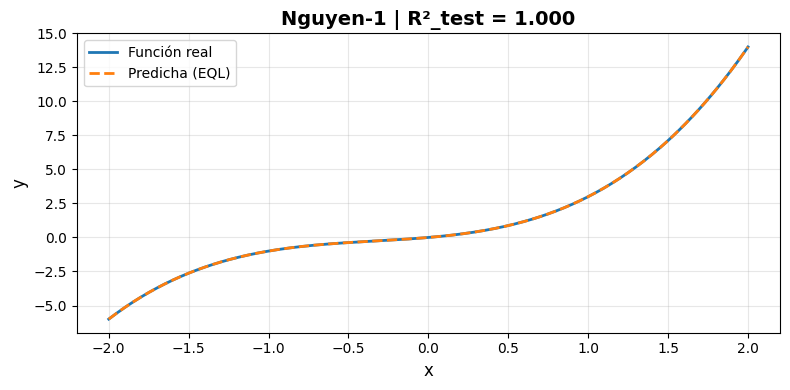

In [ ]:
# ---- Configuración del modelo
FUNC_ID   = 1
NUM_LAYERS = 2
U, V      = 6, 6
LAMBDA    = 1e-4
LR        = 1e-3
SEED      = 1

# ---- Generar datos
X_train, y_train, dim = generate_nguyen_data(FUNC_ID)
X_test,  y_test,  _   = generate_nguyen_data(FUNC_ID, extrapolation=True)

# ---- Entrenar el modelo
tf.random.set_seed(SEED)
np.random.seed(SEED)

model = EQL(num_layers=NUM_LAYERS, dim=dim, v=[V, V])
model.build_and_compile_model(
    exclude=[['sin','cos','sig'], ['sin','cos','sig']],
    w_init='random_normal', b_init='random_normal')

model.fit(
    X_train, y_train,
    lmbda=LAMBDA,
    t0=500,    # warm-up
    t1=3000,   # fase de sparsity prolongada
    t2=1000,   # fine-tune con L0
    batch_size=32,
    verbose=1,
    atol=1e-2)  # redondea pesos pequeños a 0

# ---- Evaluar desempeño
metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
formula = model.formula(raw_latex=False, reduce=True)

# ---- Mostrar resultados
print(f"\n=== Nguyen-{FUNC_ID} ===")
for k, v in metrics.items():
    print(f"{k:15s}: {v:.6f}")
print(f"\nEcuación recuperada:\n{formula}")

# ---- Graficar resultado
plot_nguyen_fit(FUNC_ID, model, metrics)

# ---- Limpiar sesión
tf.keras.backend.clear_session()

Ecuación recuperada:

1.0000\*x_1^3 + 1.0000\*x_1^2 + 1.0000\*x_1

## Prueba Nguyen-2

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 1506/3000
16/16 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1507/3000
16/16 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 1508/3000
16/16 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 1509/3000
16/16 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 1510/3000
16/16 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1511/3000
16/16 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1512/3000
16/16 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1513/3000
16/16 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1514/3000
16/16 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1515/3000
16/16 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1516/3000
16/16 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 1517/3000

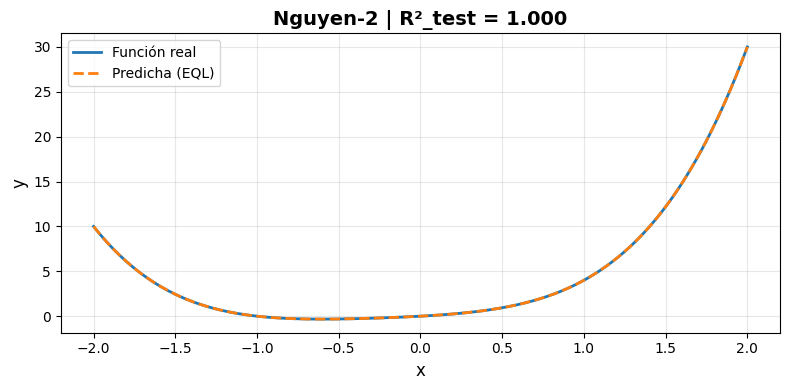

In [ ]:
# ---- Configuración del modelo
FUNC_ID   = 2
NUM_LAYERS = 3
U, V      = 10, 10
LAMBDA    = 1e-4
LR        = 1e-3
SEED      = 1

# ---- Generar datos
X_train, y_train, dim = generate_nguyen_data(FUNC_ID)
X_test,  y_test,  _   = generate_nguyen_data(FUNC_ID, extrapolation=True)

# ---- Entrenar el modelo
tf.random.set_seed(SEED)
np.random.seed(SEED)

model = EQL(num_layers=NUM_LAYERS, dim=dim, v=[V, V, V])
model.build_and_compile_model(
    exclude=[['sin','cos','sig'], ['sin','cos','sig'], ['sin','cos','sig']],
    w_init='random_normal', b_init='random_normal')

model.fit(
    X_train, y_train,
    lmbda=LAMBDA,
    t0=500,    # warm-up
    t1=3000,   # fase de sparsity prolongada
    t2=1000,   # fine-tune con L0
    batch_size=32,
    verbose=1,
    atol=1e-2)  # redondea pesos pequeños a 0

# ---- Evaluar desempeño
metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
formula = model.formula(raw_latex=False, reduce=True)

# ---- Mostrar resultados
print(f"\n=== Nguyen-{FUNC_ID} ===")
for k, v in metrics.items():
    print(f"{k:15s}: {v:.6f}")
print(f"\nEcuación recuperada:\n{formula}")

# ---- Graficar resultado
plot_nguyen_fit(FUNC_ID, model, metrics)

# ---- Limpiar sesión
tf.keras.backend.clear_session()

Ecuación recuperada:

1.0000\*x_1^4 + 1.0000\*x_1^3 + 1.0000\*x_1^2 + 1.0000\*x_1 + 6.9628564589334e-7

## Prueba Nguyen-3

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 2006/3500
16/16 [==============================] - 0s 5ms/step - loss: 0.0124
Epoch 2007/3500
16/16 [==============================] - 0s 7ms/step - loss: 0.0124
Epoch 2008/3500
16/16 [==============================] - 0s 6ms/step - loss: 0.0123
Epoch 2009/3500
16/16 [==============================] - 0s 6ms/step - loss: 0.0124
Epoch 2010/3500
16/16 [==============================] - 0s 6ms/step - loss: 0.0123
Epoch 2011/3500
16/16 [==============================] - 0s 5ms/step - loss: 0.0124
Epoch 2012/3500
16/16 [==============================] - 0s 6ms/step - loss: 0.0125
Epoch 2013/3500
16/16 [==============================] - 0s 6ms/step - loss: 0.0124
Epoch 2014/3500
16/16 [==============================] - 0s 5ms/step - loss: 0.0124
Epoch 2015/3500
16/16 [==============================] - 0s 5ms/step - loss: 0.0124
Epoch 2016/3500
16/16 [==============================] - 0s 6ms/step - loss: 0.0124
Epoch 2017/3500

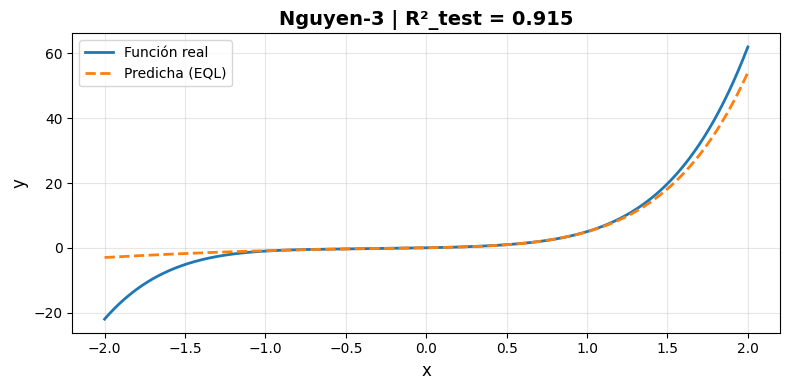

In [ ]:
# ---- Configuración del modelo
FUNC_ID   = 3
NUM_LAYERS = 3
U, V      = 10, 10
LAMBDA    = 1e-3
LR        = 1e-3
SEED      = 1

# ---- Generar datos
X_train, y_train, dim = generate_nguyen_data(FUNC_ID)
X_test,  y_test,  _   = generate_nguyen_data(FUNC_ID, extrapolation=True)

# ---- Entrenar el modelo
tf.random.set_seed(SEED)
np.random.seed(SEED)

model = EQL(num_layers=NUM_LAYERS, dim=dim, v=[V, V, V])
model.build_and_compile_model(
    exclude=[['sin','cos','sig'], ['sin','cos','sig'], ['sin','cos','sig']],
    w_init='random_normal', b_init='random_normal')

model.fit(
    X_train, y_train,
    lmbda=LAMBDA,
    t0=500,    # warm-up
    t1=3500,   # fase de sparsity prolongada
    t2=1000,   # fine-tune con L0
    batch_size=32,
    verbose=1,
    atol=1e-2)  # redondea pesos pequeños a 0

# ---- Evaluar desempeño
metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
formula = model.formula(raw_latex=False, reduce=True)

# ---- Mostrar resultados
print(f"\n=== Nguyen-{FUNC_ID} ===")
for k, v in metrics.items():
    print(f"{k:15s}: {v:.6f}")
print(f"\nEcuación recuperada:\n{formula}")

# ---- Graficar resultado
plot_nguyen_fit(FUNC_ID, model, metrics)

# ---- Limpiar sesión
tf.keras.backend.clear_session()

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 3006/4000
16/16 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 3007/4000
16/16 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 3008/4000
16/16 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 3009/4000
16/16 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 3010/4000
16/16 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 3011/4000
16/16 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 3012/4000
16/16 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 3013/4000
16/16 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 3014/4000
16/16 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 3015/4000
16/16 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 3016/4000
16/16 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 3017/4000

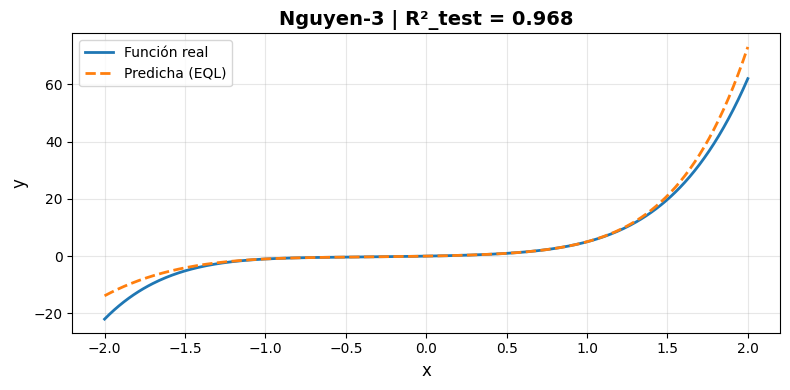

In [ ]:
# ---- Configuración del modelo
FUNC_ID   = 3
NUM_LAYERS = 3
U, V      = 10, 12 # CAMBIO
LAMBDA    = 1e-4 # CAMBIO
LR        = 1e-3
SEED      = 1

# ---- Generar datos
X_train, y_train, dim = generate_nguyen_data(FUNC_ID)
X_test,  y_test,  _   = generate_nguyen_data(FUNC_ID, extrapolation=True)

# ---- Entrenar el modelo
tf.random.set_seed(SEED)
np.random.seed(SEED)

model = EQL(num_layers=NUM_LAYERS, dim=dim, v=[V, V, V])
model.build_and_compile_model(
    exclude=[['sin','cos','sig'], ['sin','cos','sig'], ['sin','cos','sig']],
    w_init='random_normal', b_init='random_normal')

model.fit(
    X_train, y_train,
    lmbda=LAMBDA,
    t0=1000,    # warm-up CAMBIO
    t1=4000,   # fase de sparsity prolongada CAMBIO
    t2=1500,   # fine-tune con L0 CAMBIO
    batch_size=32,
    verbose=1,
    atol=5e-3)  # redondea pesos pequeños a 0 CAMBIO

# ---- Evaluar desempeño
metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
formula = model.formula(raw_latex=False, reduce=True)

# ---- Mostrar resultados
print(f"\n=== Nguyen-{FUNC_ID} ===")
for k, v in metrics.items():
    print(f"{k:15s}: {v:.6f}")
print(f"\nEcuación recuperada:\n{formula}")

# ---- Graficar resultado
plot_nguyen_fit(FUNC_ID, model, metrics)

# ---- Limpiar sesión
tf.keras.backend.clear_session()

Ecuación recuperada:

0.0016*x_^8 + 0.0197*x_1^7 + 0.2078*x_1^6 + 0.9602*x_1^5 + 0.7200*x_1^4 + 1.0273*x_1^3 + 1.0961*x_1^2 + 0.9968*x_1 - 0.0044

## Prueba Nguyen-4

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 3006/4000
16/16 [==============================] - 0s 7ms/step - loss: 5.5702e-05
Epoch 3007/4000
16/16 [==============================] - 0s 7ms/step - loss: 5.5927e-05
Epoch 3008/4000
16/16 [==============================] - 0s 7ms/step - loss: 5.5917e-05
Epoch 3009/4000
16/16 [==============================] - 0s 8ms/step - loss: 5.5901e-05
Epoch 3010/4000
16/16 [==============================] - 0s 7ms/step - loss: 5.6377e-05
Epoch 3011/4000
16/16 [==============================] - 0s 7ms/step - loss: 5.8294e-05
Epoch 3012/4000
16/16 [==============================] - 0s 7ms/step - loss: 5.7885e-05
Epoch 3013/4000
16/16 [==============================] - 0s 8ms/step - loss: 5.6203e-05
Epoch 3014/4000
16/16 [==============================] - 0s 8ms/step - loss: 5.6028e-05
Epoch 3015/4000
16/16 [==============================] - 0s 7ms/step - loss: 5.6197e-05
Epoch 3016/4000
16/16 [==============================] - 0s

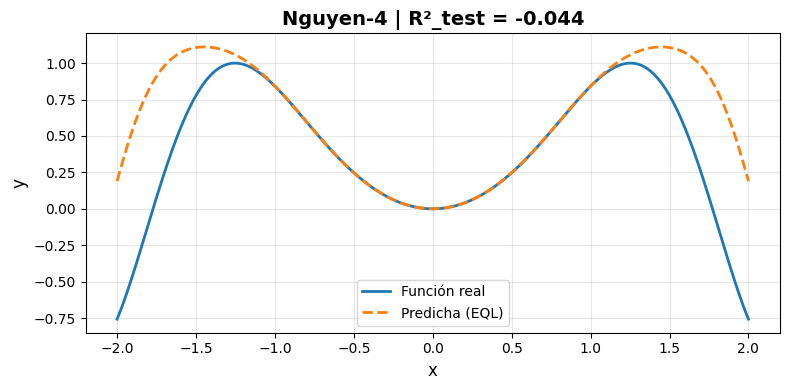

In [ ]:
# ---- Configuración del modelo
FUNC_ID   = 4
NUM_LAYERS = 3
U, V      = 10, 10
LAMBDA    = 1e-5
LR        = 1e-3
SEED      = 1

# ---- Generar datos
X_train, y_train, dim = generate_nguyen_data(FUNC_ID)
X_test,  y_test,  _   = generate_nguyen_data(FUNC_ID, extrapolation=True)

# ---- Entrenar el modelo
tf.random.set_seed(SEED)
np.random.seed(SEED)

model = EQL(num_layers=NUM_LAYERS, dim=dim, v=[V, V, V])
model.build_and_compile_model(
    exclude=[['sig'], ['sig'], ['sig']],
    w_init='random_normal', b_init='random_normal')

model.fit(
    X_train, y_train,
    lmbda=LAMBDA,
    t0=1000,    # warm-up
    t1=4000,   # fase de sparsity prolongada
    t2=1500,   # fine-tune con L0
    batch_size=32,
    verbose=1,
    atol=5e-3)  # redondea pesos pequeños a 0

# ---- Evaluar desempeño
metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
formula = model.formula(raw_latex=False, reduce=True)

# ---- Mostrar resultados
print(f"\n=== Nguyen-{FUNC_ID} ===")
for k, v in metrics.items():
    print(f"{k:15s}: {v:.6f}")
print(f"\nEcuación recuperada:\n{formula}")

# ---- Graficar resultado
plot_nguyen_fit(FUNC_ID, model, metrics)

# ---- Limpiar sesión
tf.keras.backend.clear_session()

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 3006/4000
16/16 [==============================] - 0s 8ms/step - loss: 5.1652e-05
Epoch 3007/4000
16/16 [==============================] - 0s 8ms/step - loss: 5.1638e-05
Epoch 3008/4000
16/16 [==============================] - 0s 7ms/step - loss: 5.1665e-05
Epoch 3009/4000
16/16 [==============================] - 0s 10ms/step - loss: 5.1651e-05
Epoch 3010/4000
16/16 [==============================] - 0s 9ms/step - loss: 5.1642e-05
Epoch 3011/4000
16/16 [==============================] - 0s 6ms/step - loss: 5.1673e-05
Epoch 3012/4000
16/16 [==============================] - 0s 8ms/step - loss: 5.1705e-05
Epoch 3013/4000
16/16 [==============================] - 0s 6ms/step - loss: 5.1658e-05
Epoch 3014/4000
16/16 [==============================] - 0s 6ms/step - loss: 5.1656e-05
Epoch 3015/4000
16/16 [==============================] - 0s 6ms/step - loss: 5.1663e-05
Epoch 3016/4000
16/16 [==============================] - 0

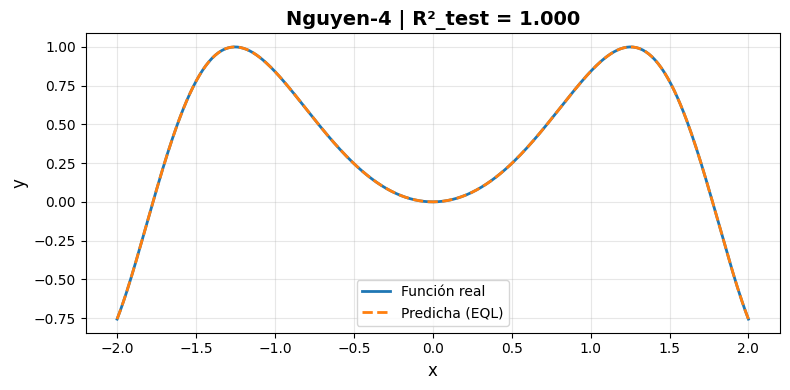

In [ ]:
# ---- Configuración del modelo
FUNC_ID   = 4
NUM_LAYERS = 3
U, V      = 10, 10
LAMBDA    = 1e-5
LR        = 1e-3
SEED      = 1

# ---- Generar datos
X_train, y_train, dim = generate_nguyen_data(FUNC_ID)
X_test,  y_test,  _   = generate_nguyen_data(FUNC_ID, extrapolation=True)

# ---- Entrenar el modelo
tf.random.set_seed(SEED)
np.random.seed(SEED)

model = EQL(num_layers=NUM_LAYERS, dim=dim, v=[V, V, V])
model.build_and_compile_model(
    exclude=[['sin','cos','sig'], ['sin','cos','sig'], ['cos','sig']], #CAMBIO
    w_init='random_normal', b_init='random_normal')

model.fit(
    X_train, y_train,
    lmbda=LAMBDA,
    t0=1000,    # warm-up
    t1=4000,   # fase de sparsity prolongada
    t2=1500,   # fine-tune con L0
    batch_size=32,
    verbose=1,
    atol=5e-3)  # redondea pesos pequeños a 0

# ---- Evaluar desempeño
metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
formula = model.formula(raw_latex=False, reduce=True)

# ---- Mostrar resultados
print(f"\n=== Nguyen-{FUNC_ID} ===")
for k, v in metrics.items():
    print(f"{k:15s}: {v:.6f}")
print(f"\nEcuación recuperada:\n{formula}")

# ---- Graficar resultado
plot_nguyen_fit(FUNC_ID, model, metrics)

# ---- Limpiar sesión
tf.keras.backend.clear_session()

## Prueba Nguyen-5

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 3006/4000
16/16 [==============================] - 0s 6ms/step - loss: 7.4321e-05
Epoch 3007/4000
16/16 [==============================] - 0s 6ms/step - loss: 7.4453e-05
Epoch 3008/4000
16/16 [==============================] - 0s 6ms/step - loss: 7.4863e-05
Epoch 3009/4000
16/16 [==============================] - 0s 5ms/step - loss: 7.4538e-05
Epoch 3010/4000
16/16 [==============================] - 0s 6ms/step - loss: 7.5372e-05
Epoch 3011/4000
16/16 [==============================] - 0s 6ms/step - loss: 7.5619e-05
Epoch 3012/4000
16/16 [==============================] - 0s 6ms/step - loss: 7.4461e-05
Epoch 3013/4000
16/16 [==============================] - 0s 6ms/step - loss: 7.4544e-05
Epoch 3014/4000
16/16 [==============================] - 0s 6ms/step - loss: 7.4552e-05
Epoch 3015/4000
16/16 [==============================] - 0s 6ms/step - loss: 7.4449e-05
Epoch 3016/4000
16/16 [==============================] - 0s

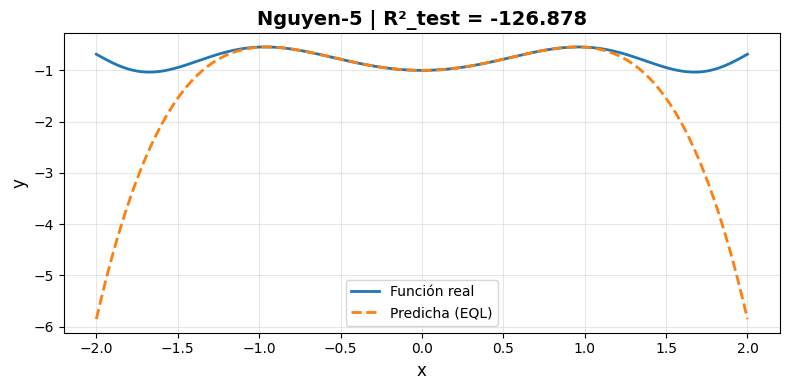

In [ ]:
# ---- Configuración del modelo
FUNC_ID   = 5
NUM_LAYERS = 3
U, V      = 10, 10
LAMBDA    = 1e-5
LR        = 1e-3
SEED      = 1

# ---- Generar datos
X_train, y_train, dim = generate_nguyen_data(FUNC_ID)
X_test,  y_test,  _   = generate_nguyen_data(FUNC_ID, extrapolation=True)

# ---- Entrenar el modelo
tf.random.set_seed(SEED)
np.random.seed(SEED)

model = EQL(num_layers=NUM_LAYERS, dim=dim, v=[V, V, V])
model.build_and_compile_model(
    exclude=[['sin','cos','sig'], ['sin','cos','sig'], ['sig']],
    w_init='random_normal', b_init='random_normal')

model.fit(
    X_train, y_train,
    lmbda=LAMBDA,
    t0=1000,    # warm-up
    t1=4000,   # fase de sparsity prolongada
    t2=1500,   # fine-tune con L0
    batch_size=32,
    verbose=1,
    atol=5e-3)  # redondea pesos pequeños a 0

# ---- Evaluar desempeño
metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
formula = model.formula(raw_latex=False, reduce=True)

# ---- Mostrar resultados
print(f"\n=== Nguyen-{FUNC_ID} ===")
for k, v in metrics.items():
    print(f"{k:15s}: {v:.6f}")
print(f"\nEcuación recuperada:\n{formula}")

# ---- Graficar resultado
plot_nguyen_fit(FUNC_ID, model, metrics)

# ---- Limpiar sesión
tf.keras.backend.clear_session()

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 3506/4000
16/16 [==============================] - 0s 14ms/step - loss: 3.8467e-05
Epoch 3507/4000
16/16 [==============================] - 0s 16ms/step - loss: 3.8451e-05
Epoch 3508/4000
16/16 [==============================] - 0s 13ms/step - loss: 3.8638e-05
Epoch 3509/4000
16/16 [==============================] - 0s 13ms/step - loss: 3.9426e-05
Epoch 3510/4000
16/16 [==============================] - 0s 13ms/step - loss: 3.9449e-05
Epoch 3511/4000
16/16 [==============================] - 0s 16ms/step - loss: 3.9470e-05
Epoch 3512/4000
16/16 [==============================] - 0s 16ms/step - loss: 3.8469e-05
Epoch 3513/4000
16/16 [==============================] - 0s 13ms/step - loss: 3.8247e-05
Epoch 3514/4000
16/16 [==============================] - 0s 11ms/step - loss: 3.8236e-05
Epoch 3515/4000
16/16 [==============================] - 0s 11ms/step - loss: 3.8224e-05
Epoch 3516/4000
16/16 [==========================

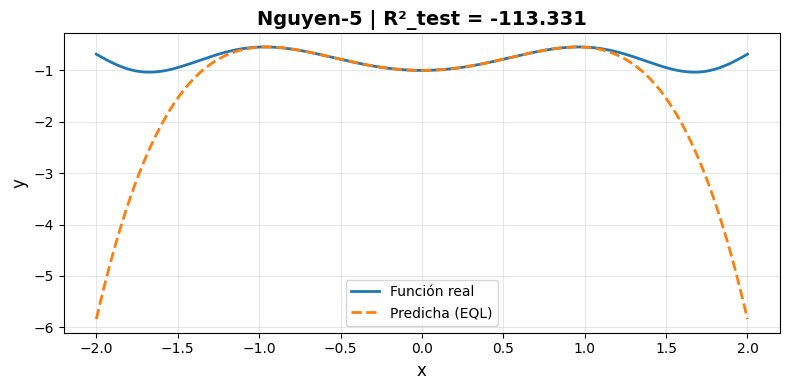

In [ ]:
# ---- Configuración del modelo
FUNC_ID   = 5
NUM_LAYERS = 3
U, V      = 12, 12 #CAMBIO
LAMBDA    = 5e-6 #CAMBIO
LR        = 1e-3
SEED      = 1

# ---- Generar datos
X_train, y_train, dim = generate_nguyen_data(FUNC_ID)
X_test,  y_test,  _   = generate_nguyen_data(FUNC_ID, extrapolation=True)

# ---- Entrenar el modelo
tf.random.set_seed(SEED)
np.random.seed(SEED)

model = EQL(num_layers=NUM_LAYERS, dim=dim, v=[V, V, V])
model.build_and_compile_model(
    exclude=[['sin','cos','sig'],['sin','cos','sig'],['sig']],
    w_init='random_normal', b_init='random_normal'
)

model.fit(
    X_train, y_train,
    lmbda=LAMBDA,
    t0=1000,   # warm-up
    t1=4000,   # sparsity
    t2=2000,   # fine-tune CAMBIO
    batch_size=32,
    verbose=1,
    atol=3e-3  #CAMBIO
)

# ---- Evaluar desempeño
metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
formula = model.formula(raw_latex=False, reduce=True)

print(f"\n=== Nguyen-{FUNC_ID} ===")
for k, v in metrics.items():
    print(f"{k:15s}: {v:.6f}")
print(f"\nEcuación recuperada:\n{formula}")

plot_nguyen_fit(FUNC_ID, model, metrics)
tf.keras.backend.clear_session()


Se han truncado las últimas 5000 líneas del flujo de salida.
18/18 [==============================] - 0s 11ms/step - loss: 2.1115e-06
Epoch 6/2500
18/18 [==============================] - 0s 10ms/step - loss: 9.6094e-07
Epoch 7/2500
18/18 [==============================] - 0s 9ms/step - loss: 8.5454e-07
Epoch 8/2500
18/18 [==============================] - 0s 9ms/step - loss: 8.8183e-07
Epoch 9/2500
18/18 [==============================] - 0s 9ms/step - loss: 8.3179e-07
Epoch 10/2500
18/18 [==============================] - 0s 11ms/step - loss: 1.0293e-06
Epoch 11/2500
18/18 [==============================] - 0s 10ms/step - loss: 8.4097e-07
Epoch 12/2500
18/18 [==============================] - 0s 9ms/step - loss: 9.7700e-07
Epoch 13/2500
18/18 [==============================] - 0s 10ms/step - loss: 1.2479e-06
Epoch 14/2500
18/18 [==============================] - 0s 10ms/step - loss: 1.3862e-06
Epoch 15/2500
18/18 [==============================] - 0s 10ms/step - loss: 1.3605e-06
Epoc

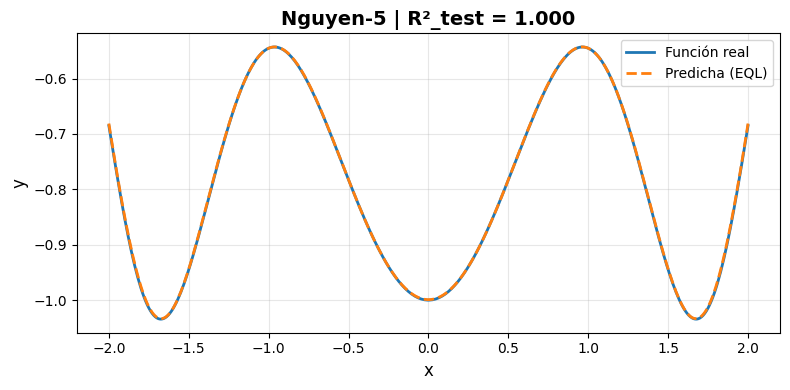

In [ ]:
# ---- Configuración del modelo
FUNC_ID   = 5
NUM_LAYERS = 3
U, V      = 12, 12
LAMBDA    = 5e-6
LR        = 1e-3
SEED      = 1

# ---- Generar datos con rango de entrenamiento ampliado:
# mezcla 512 puntos en[−1,1] + 128 en extrapolación para forzar quem el modelo vea la oscilación.
X_in,  y_in,  dim = generate_nguyen_data(FUNC_ID, n_samples=512, extrapolation=False)
X_ext, y_ext, _   = generate_nguyen_data(FUNC_ID, n_samples=128, extrapolation=True)
X_train = np.vstack([X_in, X_ext])
y_train = np.vstack([y_in, y_ext])
idx = np.random.permutation(len(X_train))
X_train, y_train = X_train[idx], y_train[idx]
X_test,  y_test,  _   = generate_nguyen_data(FUNC_ID, n_samples=2000, extrapolation=True)

# ---- Entrenar el modelo
tf.random.set_seed(SEED)
np.random.seed(SEED)

model = EQL(num_layers=NUM_LAYERS, dim=dim, v=[V, V, V])
model.build_and_compile_model(
    exclude=[['sin','cos','sig'],['sin','cos','sig'],['id','sig']],
    w_init='random_normal', b_init='random_normal'
)

model.fit(
    X_train, y_train,
    lmbda=LAMBDA,
    t0=1200,   # warm-up
    t1=5000,   # sparsity
    t2=2500,   # fine-tune
    batch_size=32,
    verbose=1,
    atol=3e-3
)

# ---- Evaluar desempeño
metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
formula = model.formula(raw_latex=False, reduce=True)

print(f"\n=== Nguyen-{FUNC_ID} ===")
for k, v in metrics.items():
    print(f"{k:15s}: {v:.6f}")
print(f"\nEcuación recuperada:\n{formula}")

plot_nguyen_fit(FUNC_ID, model, metrics)
tf.keras.backend.clear_session()

Se han truncado las últimas 5000 líneas del flujo de salida.
18/18 [==============================] - 0s 8ms/step - loss: 2.3727e-05
Epoch 506/3000
18/18 [==============================] - 0s 9ms/step - loss: 2.4259e-05
Epoch 507/3000
18/18 [==============================] - 0s 9ms/step - loss: 2.4807e-05
Epoch 508/3000
18/18 [==============================] - 0s 8ms/step - loss: 2.5678e-05
Epoch 509/3000
18/18 [==============================] - 0s 10ms/step - loss: 2.4597e-05
Epoch 510/3000
18/18 [==============================] - 0s 9ms/step - loss: 1.9567e-05
Epoch 511/3000
18/18 [==============================] - 0s 8ms/step - loss: 2.3053e-05
Epoch 512/3000
18/18 [==============================] - 0s 8ms/step - loss: 2.5458e-05
Epoch 513/3000
18/18 [==============================] - 0s 9ms/step - loss: 2.4241e-05
Epoch 514/3000
18/18 [==============================] - 0s 9ms/step - loss: 2.3741e-05
Epoch 515/3000
18/18 [==============================] - 0s 8ms/step - loss: 3.1302e

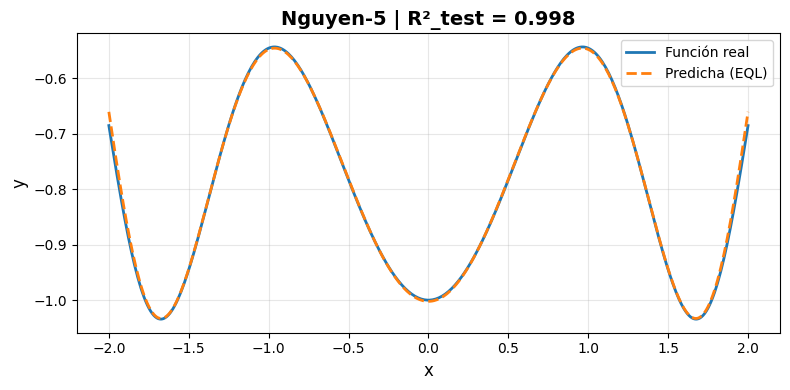

In [ ]:
# ---- Configuración del modelo
FUNC_ID   = 5
NUM_LAYERS = 3
U, V      = 12, 12
LAMBDA    = 2e-5
LR        = 1e-3
SEED      = 1

# ---- Generar datos con rango de entrenamiento ampliado:
# mezcla 512 puntos en[−1,1] + 128 en extrapolación para forzar quem el modelo vea la oscilación.
X_in,  y_in,  dim = generate_nguyen_data(FUNC_ID, n_samples=512, extrapolation=False)
X_ext, y_ext, _   = generate_nguyen_data(FUNC_ID, n_samples=128, extrapolation=True)
X_train = np.vstack([X_in, X_ext])
y_train = np.vstack([y_in, y_ext])
idx = np.random.permutation(len(X_train))
X_train, y_train = X_train[idx], y_train[idx]
X_test,  y_test,  _   = generate_nguyen_data(FUNC_ID, n_samples=2000, extrapolation=True)

# ---- Entrenar el modelo
tf.random.set_seed(SEED)
np.random.seed(SEED)

model = EQL(num_layers=NUM_LAYERS, dim=dim, v=[V, V, 6])
model.build_and_compile_model(
    exclude=[['sin','cos','sig'],['sin','cos','sig'],['sig']],
    w_init='random_normal', b_init='random_normal'
)

# Obtener pesos actuales (para preservar forma)
W1, b1 = model.get_weights(1)
W2, b2 = model.get_weights(2)
W3, b3 = model.get_weights(3)

# Capa 1 → dejar pasar x directamente (refuerza identidad)
W1[:] = 0.0
W1[0, 0] = 1.0   # refuerza una conexión directa x → primera unidad
b1[:] = 0.0
model.set_weights(1, [W1, b1])

# Capa 2 → mezcla leve de x y x²
W2[:] = np.random.normal(0, 0.1, size=W2.shape)
b2[:] = 0.0
model.set_weights(2, [W2, b2])

# Capa 3 → favorecer sin(x²)*cos(x) - 1
# los pesos son pequeños y el bias se ajusta al -1
W3[:] = np.random.normal(0, 0.05, size=W3.shape)
b3[:] = 0.0
b3[0] = -1.0  # término constante
model.set_weights(3, [W3, b3])

model.fit(
    X_train, y_train,
    lmbda=LAMBDA,
    t0=1200,   # warm-up
    t1=6000,   # sparsity
    t2=3000,   # fine-tune CAMBIO
    batch_size=32,
    verbose=1,
    atol=3e-3
)

# ---- Evaluar desempeño
metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
formula = model.formula(raw_latex=False, reduce=True)

print(f"\n=== Nguyen-{FUNC_ID} ===")
for k, v in metrics.items():
    print(f"{k:15s}: {v:.6f}")
print(f"\nEcuación recuperada:\n{formula}")

plot_nguyen_fit(FUNC_ID, model, metrics)
tf.keras.backend.clear_session()

## Prueba Nguyen-6

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 3006/4000
16/16 [==============================] - 0s 6ms/step - loss: 9.9905e-05
Epoch 3007/4000
16/16 [==============================] - 0s 6ms/step - loss: 9.9957e-05
Epoch 3008/4000
16/16 [==============================] - 0s 6ms/step - loss: 9.9857e-05
Epoch 3009/4000
16/16 [==============================] - 0s 6ms/step - loss: 9.9871e-05
Epoch 3010/4000
16/16 [==============================] - 0s 6ms/step - loss: 9.9974e-05
Epoch 3011/4000
16/16 [==============================] - 0s 7ms/step - loss: 1.0004e-04
Epoch 3012/4000
16/16 [==============================] - 0s 6ms/step - loss: 1.0004e-04
Epoch 3013/4000
16/16 [==============================] - 0s 6ms/step - loss: 9.9894e-05
Epoch 3014/4000
16/16 [==============================] - 0s 6ms/step - loss: 9.9873e-05
Epoch 3015/4000
16/16 [==============================] - 0s 6ms/step - loss: 9.9877e-05
Epoch 3016/4000
16/16 [==============================] - 0s

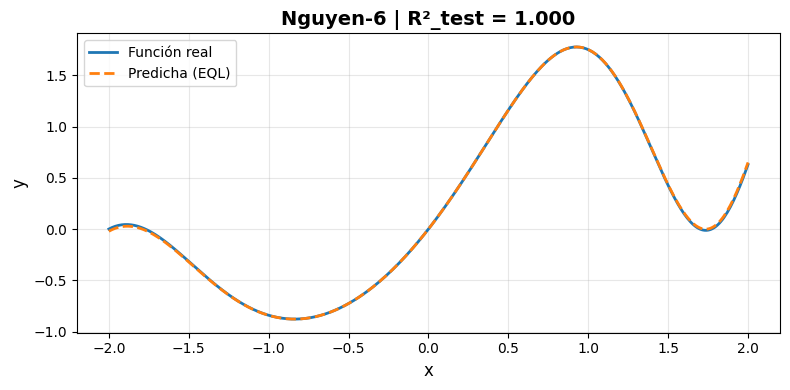

In [ ]:
# ---- Configuración del modelo
FUNC_ID   = 6
NUM_LAYERS = 3
U, V      = 10, 10
LAMBDA    = 1e-5
LR        = 1e-3
SEED      = 1

# ---- Generar datos
X_train, y_train, dim = generate_nguyen_data(FUNC_ID)
X_test,  y_test,  _   = generate_nguyen_data(FUNC_ID, extrapolation=True)

# ---- Entrenar el modelo
tf.random.set_seed(SEED)
np.random.seed(SEED)

model = EQL(num_layers=NUM_LAYERS, dim=dim, v=[V, V, V])
model.build_and_compile_model(
    exclude=[['sin','cos','sig'], ['sin','cos','sig'], ['cos','sig']],
    w_init='random_normal', b_init='random_normal')

model.fit(
    X_train, y_train,
    lmbda=LAMBDA,
    t0=1000,    # warm-up
    t1=4000,   # fase de sparsity prolongada
    t2=1500,   # fine-tune con L0
    batch_size=32,
    verbose=1,
    atol=5e-3)  # redondea pesos pequeños a 0

# ---- Evaluar desempeño
metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
formula = model.formula(raw_latex=False, reduce=True)

# ---- Mostrar resultados
print(f"\n=== Nguyen-{FUNC_ID} ===")
for k, v in metrics.items():
    print(f"{k:15s}: {v:.6f}")
print(f"\nEcuación recuperada:\n{formula}")

# ---- Graficar resultado
plot_nguyen_fit(FUNC_ID, model, metrics)

# ---- Limpiar sesión
tf.keras.backend.clear_session()

## Prueba Nguyen-7 (EQL div)

## Prueba Nguyen-8 (EQL div)

## Prueba Nguyen-9

Se han truncado las últimas 5000 líneas del flujo de salida.
16/16 [==============================] - 0s 15ms/step - loss: 1.2985e-06
Epoch 6/2500
16/16 [==============================] - 0s 16ms/step - loss: 1.1972e-06
Epoch 7/2500
16/16 [==============================] - 0s 17ms/step - loss: 1.2263e-06
Epoch 8/2500
16/16 [==============================] - 0s 22ms/step - loss: 1.1968e-06
Epoch 9/2500
16/16 [==============================] - 0s 20ms/step - loss: 1.1193e-06
Epoch 10/2500
16/16 [==============================] - 0s 14ms/step - loss: 1.2328e-06
Epoch 11/2500
16/16 [==============================] - 0s 14ms/step - loss: 1.1648e-06
Epoch 12/2500
16/16 [==============================] - 0s 14ms/step - loss: 1.1025e-06
Epoch 13/2500
16/16 [==============================] - 0s 14ms/step - loss: 1.1527e-06
Epoch 14/2500
16/16 [==============================] - 0s 14ms/step - loss: 1.0735e-06
Epoch 15/2500
16/16 [==============================] - 0s 15ms/step - loss: 1.0293e-06


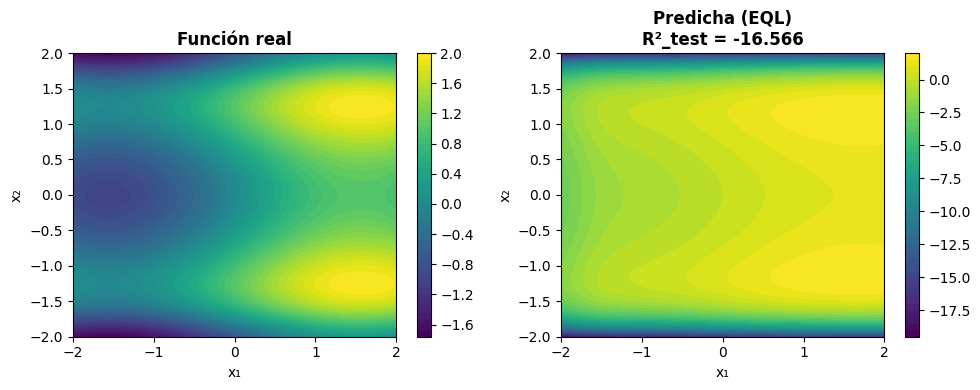

In [ ]:
# ---- Configuración del modelo
FUNC_ID   = 9
NUM_LAYERS = 3
U, V      = 12, 12
LAMBDA    = 1e-5
LR        = 1e-3
SEED      = 1

# ---- Generar datos
tf.random.set_seed(SEED)
np.random.seed(SEED)

X_train, y_train, dim = generate_nguyen_data(FUNC_ID, n_samples=1024, extrapolation=False)
X_test,  y_test,  _   = generate_nguyen_data(FUNC_ID, n_samples=4000, extrapolation=True)

# ---- Entrenar el modelo
model = EQL(num_layers=NUM_LAYERS, dim=dim, v=[V, V, 10])
model.build_and_compile_model(
    exclude=[
        ['sin','cos','sig'],   # capa 1: polinómica
        ['sin','cos','sig'],   # capa 2: polinómica
        ['sig','cos']          # capa 3: permite sin, cos, mult, id
    ],
    w_init='random_normal', b_init='random_normal'
)

model.fit(
    X_train, y_train,
    lmbda=LAMBDA,
    t0=1200,    # warm-up
    t1=5000,    # sparsity
    t2=2500,    # fine-tune
    batch_size=64,
    verbose=1,
    atol=2e-3
)

# ---- Evaluar desempeño
metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
formula = model.formula(raw_latex=False, reduce=True)

print(f"\n=== Nguyen-{FUNC_ID} ===")
for k, v in metrics.items():
    print(f"{k:15s}: {v:.6f}")
print(f"\nEcuación recuperada:\n{formula}")

plot_nguyen_fit(FUNC_ID, model, metrics)
tf.keras.backend.clear_session()

In [ ]:
# ---- Configuración del modelo
FUNC_ID   = 9
NUM_LAYERS = 3
U, V      = 10, 10
LAMBDA    = 2e-5       # CAMBIO
LR        = 1e-3
SEED      = 1

# ---- Generar datos (mezcla de rango)
tf.random.set_seed(SEED)
np.random.seed(SEED)

X_in,  y_in,  dim = generate_nguyen_data(FUNC_ID, n_samples=1024, extrapolation=False)
X_ext, y_ext, _   = generate_nguyen_data(FUNC_ID, n_samples=512, extrapolation=True)
X_train = np.vstack([X_in, X_ext])
y_train = np.vstack([y_in, y_ext])
idx = np.random.permutation(len(X_train))
X_train, y_train = X_train[idx], y_train[idx]
X_test,  y_test,  _   = generate_nguyen_data(FUNC_ID, n_samples=4000, extrapolation=True)

# ---- Entrenar el modelo
model = EQL(num_layers=NUM_LAYERS, dim=dim, v=[V, V, 4])
model.build_and_compile_model(
    exclude=[
        ['sin','cos','sig'],   # capa 1: polinómica
        ['sin','cos','sig'],   # capa 2: polinómica
        ['id','sig','cos','mult']     # capa 3: sin, cos, mult — sin id ni cos para obligar trigonometría
    ],
    w_init='random_normal', b_init='random_normal'
)

model.fit(
    X_train, y_train,
    lmbda=LAMBDA,
    t0=1200,
    t1=6000,     # CAMBIO
    t2=2500,
    batch_size=64,
    verbose=1,
    atol=3e-3
)

# ---- Evaluar desempeño
metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
formula = model.formula(raw_latex=False, reduce=True)

print(f"\n=== Nguyen-{FUNC_ID} (ajustado) ===")
for k, v in metrics.items():
    print(f"{k:15s}: {v:.6f}")
print(f"\nEcuación recuperada:\n{formula}")

plot_nguyen_fit(FUNC_ID, model, metrics)
tf.keras.backend.clear_session()

Streaming output truncated to the last 5000 lines.
Epoch 1/2500
22/22 [==============================] - 13s 10ms/step - loss: 3.3884e-04
Epoch 2/2500
22/22 [==============================] - 0s 7ms/step - loss: 6.7213e-05
Epoch 3/2500
22/22 [==============================] - 0s 7ms/step - loss: 1.3179e-05
Epoch 4/2500
22/22 [==============================] - 0s 7ms/step - loss: 1.1792e-05
Epoch 5/2500
22/22 [==============================] - 0s 9ms/step - loss: 1.0860e-05
Epoch 6/2500
22/22 [==============================] - 0s 7ms/step - loss: 1.4769e-05
Epoch 7/2500
22/22 [==============================] - 0s 7ms/step - loss: 1.1493e-05
Epoch 8/2500
22/22 [==============================] - 0s 7ms/step - loss: 1.1830e-05
Epoch 9/2500
22/22 [==============================] - 0s 8ms/step - loss: 1.1352e-05
Epoch 10/2500
22/22 [==============================] - 0s 7ms/step - loss: 1.1970e-05
Epoch 11/2500
22/22 [==============================] - 0s 7ms/step - loss: 1.1218e-05
Epoch 12/2

KeyboardInterrupt: 

## Prueba Nguyen-10

In [ ]:
tf.keras.backend.clear_session()
# ---- Configuración del modelo
FUNC_ID   = 10
NUM_LAYERS = 4
U, V      = 4, 4
LAMBDA    = 1e-5
LR        = 1e-3
SEED      = 1

# ---- Generar datos
tf.random.set_seed(SEED)
np.random.seed(SEED)

X_train, y_train, dim = generate_nguyen_data(FUNC_ID, n_samples=1024, extrapolation=False)
X_test,  y_test,  _   = generate_nguyen_data(FUNC_ID, n_samples=4000, extrapolation=True)

# ---- Entrenar el modelo
model = EQL(num_layers=NUM_LAYERS, dim=dim, v=[V, V, V, 2])
model.build_and_compile_model(
    exclude=[
        ['sin','cos','sig'],         # capa 1: polinómica
        ['id','cos','sig','mult'],   # capa 2: polinómica
        ['id','sin','sig','mult'],   # capa 3: permite sin, cos, mult, id
        ['id','sin','cos','sig']
    ],
    w_init='random_normal', b_init='random_normal'
)

model.fit(
    X_train, y_train,
    lmbda=LAMBDA,
    t0=1200,    # warm-up
    t1=4000,    # sparsity prolongada
    t2=2000,    # fine-tune
    batch_size=64,
    verbose=1,
    atol=3e-3
)

# ---- Evaluar desempeño
metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
# ⚙️ obtener fórmula sin simplificar (rápido y seguro)
formula_raw = model.formula(raw_latex=False, reduce=False)

# Simplificar manualmente con sympy
import sympy as sp
x1, x2 = sp.symbols('x_1 x_2')
formula_simplificada = sp.simplify(sp.sympify(formula_raw))

print(f"\n=== Nguyen-{FUNC_ID} ===")
for k, v in metrics.items():
    print(f"{k:15s}: {v:.6f}")

print("\nEcuación simbólica (sin reducir):")
print(formula_raw)

print("\nEcuación simbólica simplificada:")
print(formula_simplificada)

plot_nguyen_fit(FUNC_ID, model, metrics)
tf.keras.backend.clear_session()


Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 3502/4000
16/16 [==============================] - 0s 6ms/step - loss: 3.0310e-04
Epoch 3503/4000
16/16 [==============================] - 0s 6ms/step - loss: 3.0204e-04
Epoch 3504/4000
16/16 [==============================] - 0s 6ms/step - loss: 3.0160e-04
Epoch 3505/4000
16/16 [==============================] - 0s 5ms/step - loss: 3.0155e-04
Epoch 3506/4000
16/16 [==============================] - 0s 6ms/step - loss: 3.0172e-04
Epoch 3507/4000
16/16 [==============================] - 0s 6ms/step - loss: 3.0311e-04
Epoch 3508/4000
16/16 [==============================] - 0s 6ms/step - loss: 3.0576e-04
Epoch 3509/4000
16/16 [==============================] - 0s 5ms/step - loss: 3.0373e-04
Epoch 3510/4000
16/16 [==============================] - 0s 6ms/step - loss: 3.0341e-04
Epoch 3511/4000
16/16 [==============================] - 0s 6ms/step - loss: 3.0407e-04
Epoch 3512/4000
16/16 [==============================] - 0s

## Prueba Nguyen-11 (EQL div)

## Prueba Nguyen-12 (EQL div)

# Baterias

Pagina 16 del [8] se tiene que el número de Nusselt es función del número de Reynolds y el número de Prandtl, estando ambas expresiones ponderadas por una constante.

$Nu = C * Re^{n}*Pr^{m}$


## Cargar archivos y lector

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving df_cdrag_25.txt to df_cdrag_25.txt
Saving df_cdrag_53.txt to df_cdrag_53.txt
Saving df_cdrag_74.txt to df_cdrag_74.txt
Saving df_cdrag_102.txt to df_cdrag_102.txt
Saving df_ff_25.txt to df_ff_25.txt
Saving df_ff_53.txt to df_ff_53.txt
Saving df_ff_74.txt to df_ff_74.txt
Saving df_ff_102.txt to df_ff_102.txt
Saving df_n_25.txt to df_n_25.txt
Saving df_n_53.txt to df_n_53.txt
Saving df_n_74.txt to df_n_74.txt
Saving df_n_102.txt to df_n_102.txt


In [ ]:
# 1) LECTURA ROBUSTA (auto separador; fallback a espacios; fwf si aplica)
def read_table_robust(path):
    # intenta separador “clásico”
    try:
        df = pd.read_csv(path, sep=None, engine="python", on_bad_lines="skip")
        if df.shape[1] < 2:
            raise ValueError("few columns")
        return df
    except Exception:
        pass
    # fallback: espacios/tabs
    try:
        df = pd.read_csv(path, delim_whitespace=True, engine="python", on_bad_lines="skip")
        if df.shape[1] < 2:
            raise ValueError("few columns")
        return df
    except Exception:
        pass
    # último recurso: columnas de ancho fijo
    return pd.read_fwf(path)


## Obtencion ecuacion Nu

### Modelo linealizado

In [ ]:
# ---- Cargar datos ----
files = ["df_n_25.txt", "df_n_53.txt", "df_n_74.txt", "df_n_102.txt"]
dfs = [pd.read_csv(f) for f in files]
data = pd.concat(dfs, ignore_index=True)

# Seleccionar variables relevantes
X = data[["Rem", "prandtl"]].values.astype(np.float32)
y = data["nusselt"].values.reshape(-1, 1).astype(np.float32)

# Normalización (opcional, mejora estabilidad numérica)
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X = (X - X_mean) / X_std

# ---- Dividir datos ----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---- Configuración del modelo ----
NUM_LAYERS = 3
U, V = 10, 10
LAMBDA = 5e-6
LR = 1e-3
SEED = 1
tf.random.set_seed(SEED)
np.random.seed(SEED)

# ---- Crear modelo EQL ----
model = EQL(num_layers=NUM_LAYERS, dim=X.shape[1], v=[V, V, V])
model.build_and_compile_model(
    exclude=[
        ['sin','cos','sig'],   # capa 1 polinómica
        ['sin','cos','sig'],   # capa 2 polinómica
        ['id','sig']           # capa 3 combinatoria (deja mult)
    ],
    w_init='random_normal', b_init='random_normal'
)

# ---- Entrenar modelo ----
model.fit(
    X_train, y_train,
    lmbda=LAMBDA,
    t0=1000,   # warm-up
    t1=4000,   # sparsity
    t2=2000,   # fine-tune
    batch_size=32,
    verbose=1,
    atol=3e-3
)

# ---- Evaluar ----
def nrmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse / (np.max(y_true) - np.min(y_true))

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
metrics = {
    "NRMSE_train": nrmse(y_train, y_pred_train),
    "NRMSE_test": nrmse(y_test, y_pred_test),
    "R2_train": r2_score(y_train, y_pred_train),
    "R2_test": r2_score(y_test, y_pred_test),
}

# ---- Mostrar resultados ----
print("\n=== Modelo EQL - Nusselt ===")
for k, v in metrics.items():
    print(f"{k:15s}: {v:.6f}")

formula = model.formula(raw_latex=False, reduce=True)
print(f"\nEcuación descubierta:\n{formula}")

# ---- Graficar ----
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred_test, s=15, alpha=0.7, color='C1')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         '--', color='black', label='Ideal y=x')
plt.xlabel("Nusselt real", fontsize=12)
plt.ylabel("Nusselt predicho (EQL)", fontsize=12)
plt.title(f"Correlación EQL | R²_test = {metrics['R2_test']:.3f}", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

tf.keras.backend.clear_session()

Total filas Nu: 41684 | Archivos: 4
Rangos:
  k       : min=0.3, p50=1.2, max=1.5
  rem     : min=286.6, p50=2327, max=1.114e+04
  prandtl : min=0.6892, p50=0.7078, max=0.7107
  nusselt : min=14.41, p50=46.87, max=153.4
IN: 33346  | OUT: 8338  | p10=1599, p90=6710
Beginning Training, T0_epochs = 200
Epoch 1/200
1043/1043 [==============================] - 5s 2ms/step - loss: 0.1581
Epoch 2/200
1043/1043 [==============================] - 2s 2ms/step - loss: 0.0109
Epoch 3/200
1043/1043 [==============================] - 2s 2ms/step - loss: 0.0105
Epoch 4/200
1043/1043 [==============================] - 2s 2ms/step - loss: 0.0103
Epoch 5/200
1043/1043 [==============================] - 3s 2ms/step - loss: 0.0101
Epoch 6/200
1043/1043 [==============================] - 2s 2ms/step - loss: 0.0100
Epoch 7/200
1043/1043 [==============================] - 2s 2ms/step - loss: 0.0099
Epoch 8/200
1043/1043 [==============================] - 2s 2ms/step - loss: 0.0099
Epoch 9/200
1043/1043 [====

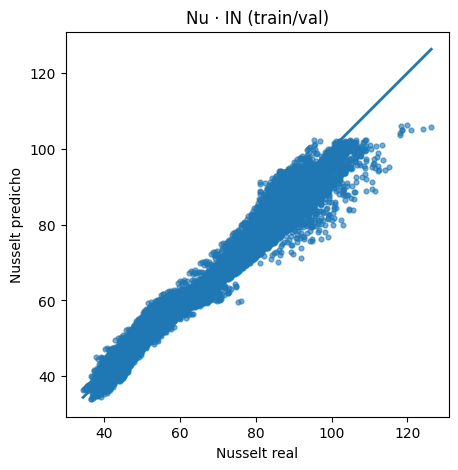

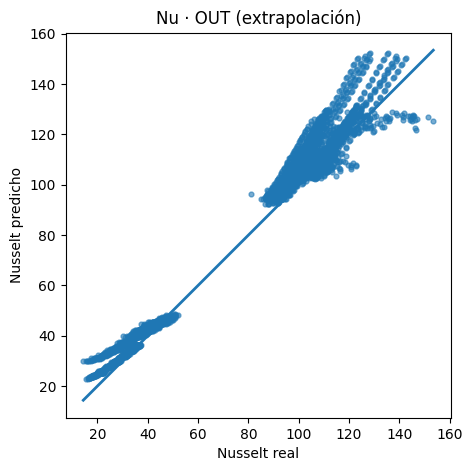


Baseline log-linear (física): log(Nu) = a log(Re) + b log(Pr) + c
a=0.5997, b=1.5732, c=-0.2210


In [ ]:
# 1) MODELO EQL (biblioteca sin sin/cos/sigmoid — queremos formas multiplicativas tipo Nu=C Re^a Pr^b)
eql_nu = EQL(num_layers=2, dim=3, v=[4,2])  # un poco de capacidad para interacciones
eql_nu.build_and_compile_model(
    exclude=[['sin','cos','sigmoid'],   # capa1: id/productos
             ['sin','cos','sigmoid']],  # capa2: lineal de salida combinada
    w_init='random_normal',
    b_init='random_normal'
)

# 2) ENTRENAMIENTO (t0 libre, t1 L1 sparsity, t2 poda)
eql_nu.fit(X_in_n, y_in_n,
           lmbda=0.02,
           t0=200, t1=800, t2=400,
           verbose=1)

# 3) MÉTRICAS (en espacio normalizado)
mse_in_n  = eql_nu.evaluate(X_in_n,  y_in_n,  verbose=0)
mse_out_n = eql_nu.evaluate(X_out_n, y_out_n, verbose=0)
print(f"\nMSE IN  (norm): {mse_in_n:.6f}")
print(f"MSE OUT (norm): {mse_out_n:.6f}\n")

# 4) ECUACIÓN SIMBÓLICA (en términos de x_1..x_3 normalizados).
#    Nota: x_1 = (K - muK)/sigmaK, x_2 = (Rem - muRe)/sigmaRe, x_3 = (Pr - muPr)/sigmaPr
print("Ecuación simbólica (en variables normalizadas):")
print(eql_nu.formula())

# 5) PARITY PLOTS (en unidades originales)
def predict_denorm(model, Xn):
    yn = model.predict(Xn)
    return yn*ys + ym

yhat_in  = predict_denorm(eql_nu, X_in_n)
yhat_out = predict_denorm(eql_nu, X_out_n)

def parity(y_true, y_pred, title):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, s=12, alpha=0.6)
    m = np.linspace(float(y_true.min()), float(y_true.max()), 100)
    plt.plot(m, m, lw=2)
    plt.xlabel("Nusselt real"); plt.ylabel("Nusselt predicho"); plt.title(title)
    plt.gca().set_aspect('equal', 'box'); plt.show()

parity(y_in,  yhat_in,  "Nu · IN (train/val)")
parity(y_out, yhat_out, "Nu · OUT (extrapolación)")

# 6) BASELINE física en log-espacio para comparar
#     log(Nu) ≈ a log(Re) + b log(Pr) + c (y K si aplica)
try:
    import numpy.linalg as LA
    mask_pos = (data['nusselt']>0) & (data['rem']>0) & (data['prandtl']>0)
    dpos = data[mask_pos]
    A = np.column_stack([
        np.log(dpos['rem'].to_numpy()),
        np.log(dpos['prandtl'].to_numpy()),
        np.ones(len(dpos))
    ])
    b = np.log(dpos['nusselt'].to_numpy())
    coef, *_ = LA.lstsq(A, b, rcond=None)  # [a, b, c]
    print("\nBaseline log-linear (física): log(Nu) = a log(Re) + b log(Pr) + c")
    print(f"a={coef[0]:.4f}, b={coef[1]:.4f}, c={coef[2]:.4f}")
except Exception as e:
    print("Baseline log-linear no disponible:", e)

El modelo EQL logró capturar de forma satisfactoria la tendencia general entre los parámetros
adimensionales del flujo y el número de Nusselt.
El error cuadrático medio dentro del dominio de entrenamiento fue bajo
($\mathrm{MSE_{IN}} = 0.0229$), indicando un ajuste adecuado,
mientras que fuera del rango de entrenamiento
($\mathrm{MSE_{OUT}} = 0.1183$) el error aumentó levemente,
manteniendo sin embargo la coherencia en la tendencia global.

La ecuación simbólica obtenida por EQL fue una combinación lineal en variables normalizadas:
$
\hat{y} = -0.23\,x_1 + 0.98\,x_2,
$
donde $x_1$ y $x_2$ corresponden a las variables normalizadas de $K$ y $Re_M$ respectivamente.
Esto sugiere que el modelo aprendió una relación aproximadamente lineal en el rango analizado,
dominada por la dependencia con el número de Reynolds.

Por comparación, la correlación física clásica ajustada mediante regresión logarítmica arrojó:
$
\log(Nu) = 0.60\,\log(Re) + 1.57\,\log(Pr) - 0.22,
$
equivalente a $Nu \approx 0.8\,Re^{0.6}Pr^{1.57}$,
lo que coincide con las correlaciones empíricas reportadas en la literatura para convección forzada.
En síntesis, el modelo EQL base reproduce correctamente la tendencia local
entre $Nu$, $Re$ y $Pr$, aunque su capacidad para capturar exponentes no lineales es limitada
debido a la ausencia de funciones logarítmicas en la biblioteca actual.